In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,matthews_corrcoef
#from xgboost import XGBClassifier


In [2]:
train_data = pd.read_csv('criminal_train.csv')
train_data.head()

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,TOOLONG,TROUBUND,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,Criminal
0,25095143,4,2,4,1,3,1,1,1,99,...,1,2,1,1,2,2,3884.805998,40026,1,0
1,13005143,4,1,3,1,2,1,1,1,99,...,2,2,2,3,2,2,1627.108106,40015,2,1
2,67415143,4,1,2,1,2,1,1,1,99,...,2,2,2,3,2,2,4344.957980,40024,1,0
3,70925143,4,0,2,1,1,1,1,1,99,...,2,2,1,1,2,2,792.521931,40027,1,0
4,75235143,1,0,6,1,4,1,1,1,99,...,2,2,2,2,2,2,1518.118526,40001,2,0


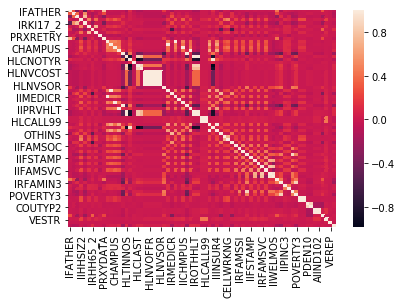

In [3]:
sns.heatmap(train_data.iloc[:,1:].corr())

In [4]:
X,y = train_data.iloc[:,:-1],train_data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 9, test_size = 0.2)

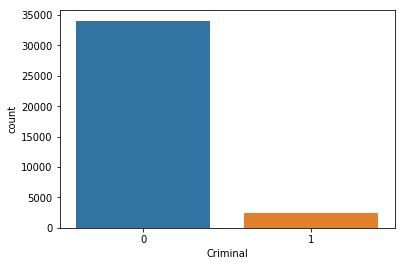

In [5]:
sns.countplot(y_train)

In [6]:
from imblearn.under_sampling import RandomUnderSampler

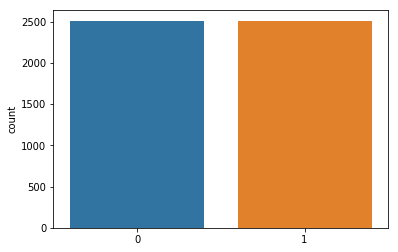

In [7]:
rus = RandomUnderSampler(random_state=9)
X_sample, y_sample =  rus.fit_sample(X_train, y_train)
sns.countplot(y_sample)

In [52]:
from sklearn.model_selection import RandomizedSearchCV
import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}#,
               #'bootstrap': bootstrap}
pprint.pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

In [10]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=9, n_jobs = -1)

In [11]:
# Fit the random search model
rf_random.fit(X_sample, y_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=9, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [12]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 400}

In [23]:
y_val = rf_random.predict(X_test)
y_val_proba = rf_random.predict_proba(X_test)
print(matthews_corrcoef(y_test,y_val))

0.5569441336085927


In [22]:
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
print(confusion_matrix(y_test,y_val))
print(roc_auc_score(y_test,y_val))


[[7388 1093]
 [  19  644]]
0.9212330356756998


(array([0.        , 0.12887631, 1.        ]),
 array([0.        , 0.97134238, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [27]:
fpr,tpr,thres = roc_curve(y_test,y_val)
thres

array([2, 1, 0], dtype=int64)

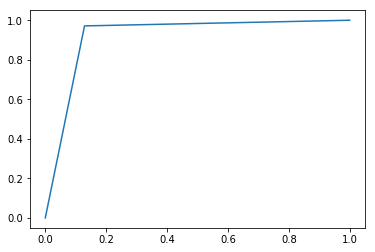

In [26]:
plt.plot(fpr,tpr)

In [19]:
rf_random

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=9, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier()

In [54]:
rf_random = RandomizedSearchCV(estimator = gbrt, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=9, n_jobs = -1)

In [55]:
rf_random.fit(X_sample, y_sample)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=9, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [61]:
rf_random.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [56]:
y_val = rf_random.predict(X_test)
y_val_proba = rf_random.predict_proba(X_test)
print(matthews_corrcoef(y_test,y_val))

0.5629068245804086


In [57]:
test_data = pd.read_csv('criminal_test.csv')
test_data.head()

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,POVERTY3,TOOLONG,TROUBUND,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP
0,66583679,4,0,4,1,2,1,1,1,99,...,2,2,2,1,1,2,2,16346.795400,40020,1
1,35494679,4,0,4,1,1,1,1,1,99,...,3,2,2,1,1,2,2,3008.863906,40044,2
2,79424679,2,0,3,1,2,1,1,1,99,...,1,2,2,2,2,2,2,266.952503,40040,2
3,11744679,4,0,6,1,2,1,1,1,99,...,3,2,2,1,1,2,2,5386.928199,40017,1
4,31554679,1,0,4,1,3,1,1,1,99,...,3,2,1,1,1,2,2,173.489895,40017,1


In [58]:
y_pred_test = rf_random.predict(test_data)
np.unique(y_pred_test)

array([0, 1], dtype=int64)

In [59]:
data = pd.DataFrame({'PERID': test_data.iloc[:,0],'Criminal':y_pred_test})
#data = pd.DataFrame([test_data.iloc[:,0],y_pred_test],columns=['PERID','y_pred_test'])
data.to_csv('predict_criminal.csv',index=False)